In [61]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.externals 
import joblib
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName ='AllData.csv', AltPath=None,Site='FishIsland',FPVars=None):
        self.FPVars = FPVars
        self.target = target        
        self.params = Dense.Params(Path,'Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName,FPVars = FPVars)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'           
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
#         pool = Pool(processes=1,maxtasksperchild=75) 
#         for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(0,1))):

        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
#             self.Model=results[1]
#             YVar = self.RST.YvarScaled.inverse_transform(YVar)    
            YVar = YStandard.inverse_transform(YVar)                    
#         pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     
    # print(fch4.RST.X_fill.shape)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:#,'ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
        #         temp=open(Path+f+'_Removed.txt', "r")
        #         AllRes[f]['Removed'] = temp.read().split(',')
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)

Variables=['H','LE','fco2','fch4',
           'wind_speed','air_pressure','AirTC_Avg','NR_Wm2_Avg',
           'PPFD_Avg',
           'Table_1','Temp_2_5_1','Temp_2_5_2','Temp_5_1',
           'Temp_5_2','Temp_15_1','Temp_15_2','Ts All Cent',
           'Ts All Rim','VWC_2','VWC_1','Active_Layer_1','24H Rain',
           'wind_dir','ER','Time','DOY',
           'VPD','u*','Wind_Direction','Delta_Table_1',
           'Rolling_Temp_15_1','Delta_air_pressure','Anoxic_Depth','Ratio',
           'Active_Layer_2','Rolling_NR_Wm2_Avg',
              'Rim','Collapse','Polygon','Daytime','nan']
Aliases=['Sensible Heat Flux','Latent Heat Flux','Net Ecosystem Exchange','Net Methante Exchange',
         'Wind Speed','Air Pressure','Air Temperature','Net Radiation',
         'Photon Flux Density',
         'Water Table Depth','Polygon Center Temperature 2.5cm','Polygon Rim Temp. 2.5cm','Polygon Center Temp. 5cm',
         'Polygon Rim Temp. 5cm','Polygon Center Temp. 15cm','Polygon Rim Temp. 15cm','Ts All Cent',
         'Ts All Rim','Volumetric Water Content (Rim)','Center','Thaw Depth','24H Rain','Dir','Ecosystem Respiration','Time','Day of Year',
         'Vapor Pressure Deficit','Friction Velocity','Wind Direction','DW$_{TD}$',
         'Mean T$_{s 15 cm Cnt}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'Rim Fraction','Tro Fraction','Cnt Fraction','Daytime','nan']


Abbreviations=['H','LE','NEE','NME',
         'U','Pa','T$_{a}$','Rn',
         'PPFD',
         'W$_{TD}$','T$_{Cnt 2.5}$','T$_{Rim 2.5}$','T$_{Cnt 5}$',
         'T$_{Rim 5}$','T$_{Cnt 15}$','T$_{Rim 15}$','Ts All Cent',
         'Ts All Rim','VWC$_{Rim}$','VWC$_{Cnt}$','TD','24H Rain','Dir','ER','Time','DOY','VPD','u$^*$','Wind Dir','DW$_{TD}$',
         'Mean T$_{s 15 cm Cnt}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'F$_{Rim}$','F$_{Tro}$','F$_{Cnt}$','Daytime','nan']


NameDict = {}
for k,n in zip(Variables,Aliases):
    NameDict[k]=n
    
AbbrevDict = {}
for k,n in zip(Variables,Abbreviations):
    AbbrevDict[k]=n 

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [62]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'
Site = 'FishIsland_Paper/'
# Site = 'FishIsland/'
Path = Path+Site
AllRes = RecRead(Path = Path) 

# fig,ax = plt.subplots(1,2,figsize=(5,5))
# fyg,ax2 = plt.subplots(1,figsize=(3.5,4))

for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
#     print(Records['Remove'])
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
    #     print(I)
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    for v in Records.Remove:
        try:
            Xlbls.append(NameDict[v])
        except:
            Xlbls.append('N/A')
            pass
    df = df.iloc[::-1]
    df['Factor']=Xlbls[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
#     print(Mn[['Factor','R2','RMSE','Diff','MBE']].round(3))
    print(df[['Factor','R2','RMSE','Diff','MBE','PCT']].round(3)[::-1])
    

      Factor     R2   RMSE   Diff    MBE    PCT
21_75    N/A  0.945  0.349    NaN -0.000  1.000
10_75    N/A  0.935  0.380  0.031  0.003  0.919
      Factor     R2   RMSE   Diff    MBE    PCT
21_43    N/A  0.737  6.458    NaN  0.099  1.000
9_43     N/A  0.719  6.674  0.216  0.092  0.968


                                                                                                                                                                                          Model  \
21_43  AirTC_Avg+VPD+u*+wind_speed+air_pressure+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+VWC_1+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_2+Collapse+Polygon+Rim+Daytime   
9_43                                                                                                            VPD+u*+wind_speed+NR_Wm2_Avg+Table_1+Active_Layer_1+Temp_15_1+Temp_15_2+Daytime   

       Size  Nodes        MSE      RMSE        SE        r2  Performance   K  \
21_43    21     43  36.030448  6.002537  0.608700  0.776564            0  30   
9_43      9     43  41.778270  6.463611  0.691673  0.740920            0  30   

          Thresh  Remove  
21_43  36.639148     NaN  
9_43   42.469943     NaN  
                                                                                Model  \
9_4

<IPython.core.display.Javascript object>


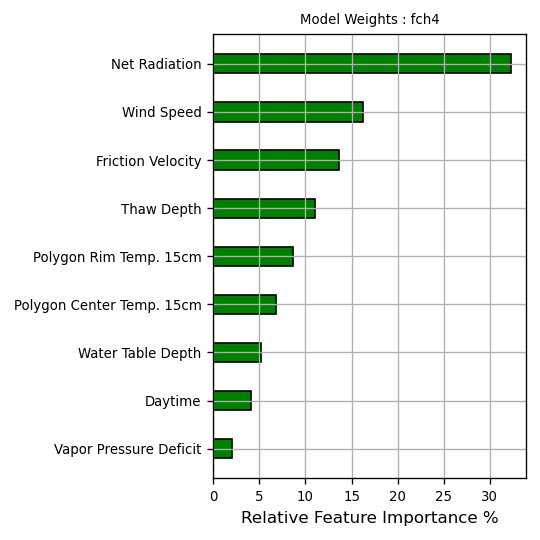

<IPython.core.display.Javascript object>


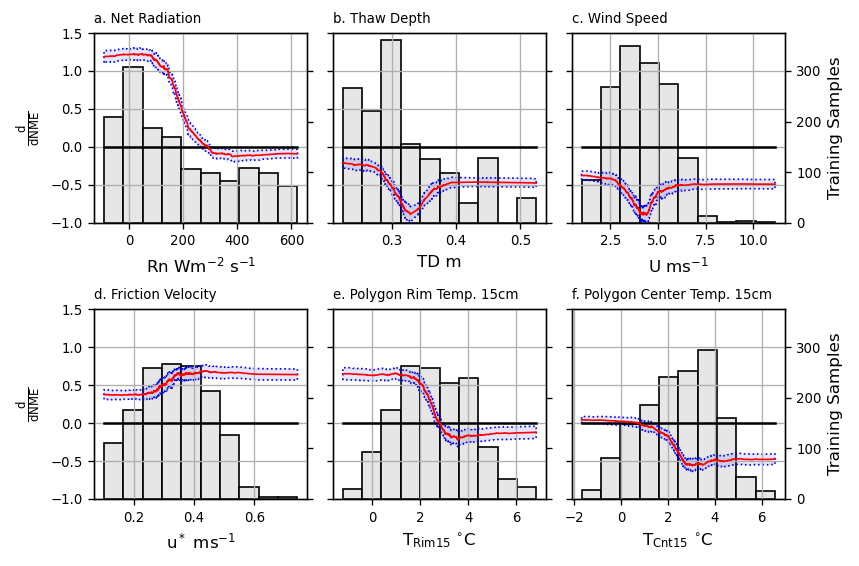

NR_Wm2_Avg -0.12851787408192952
X    290.900000
Y     -0.000812
dtype: float64
Net Influence
979.7774769459542

Active_Layer_1 -0.8904289245605469
X    0.225403
Y   -0.211186
dtype: float64
Net Influence
-662.5632911607468

wind_speed -0.9011827339728673
X    1.320651
Y   -0.377537
dtype: float64
Net Influence
-850.812223814552

u* 0.3675456556181113
X    0.162013
Y    0.367546
dtype: float64
Net Influence
788.431276655818

Temp_15_2 -0.21882322616875172
X    2.826000
Y    0.009295
dtype: float64
Net Influence
316.69553424433497

Temp_15_1 -0.5614067614078522
X    0.712000
Y   -0.000095
dtype: float64
Net Influence
-448.24313505521667

                                                                                                                                                                                          Model  \
21_75  AirTC_Avg+VPD+u*+wind_speed+air_pressure+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+VWC_1+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_

<IPython.core.display.Javascript object>


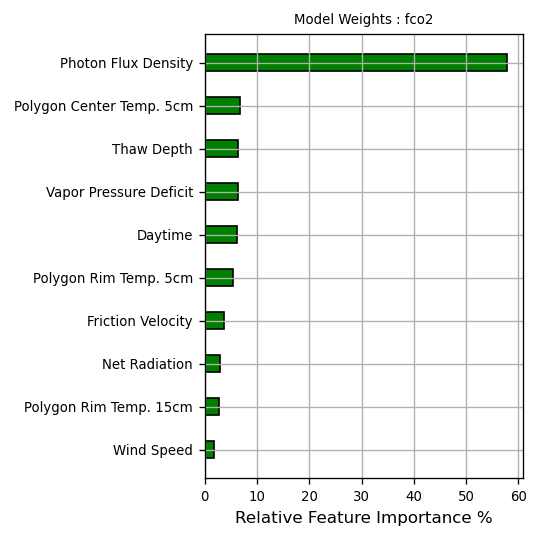

<IPython.core.display.Javascript object>


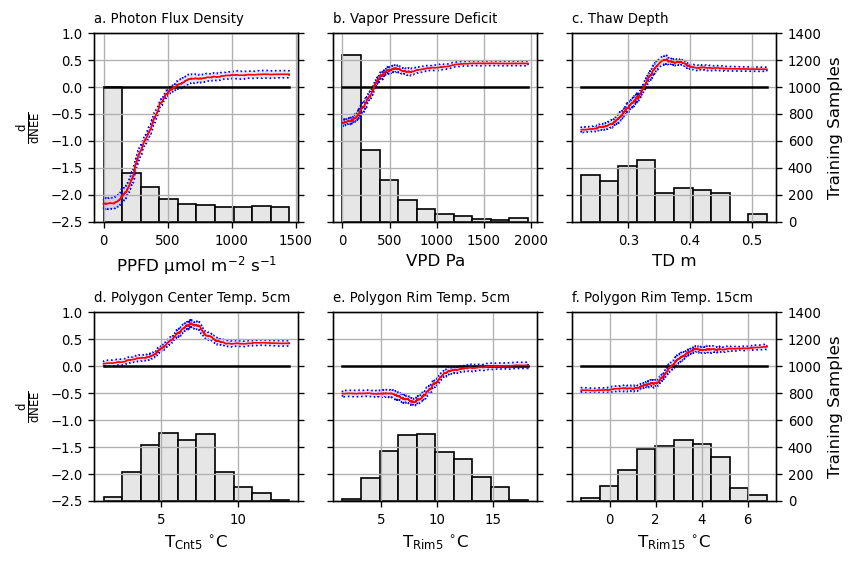

PPFD_Avg -2.165293347835541
X    548.850000
Y      0.000488
dtype: float64
Net Influence
-2837.8707970805

VPD -0.6690968304872513
X    336.935364
Y     -0.000735
dtype: float64
Net Influence
-615.3603125498553

Active_Layer_1 -0.7921813726425171
X    0.325201
Y   -0.000131
dtype: float64
Net Influence
-212.46584995084754

Temp_5_1 0.04296529075751702
X    1.254000
Y    0.042965
dtype: float64
Net Influence
1136.567013461329

Temp_5_2 -0.6720977773269018
X    15.360000
Y    -0.000133
dtype: float64
Net Influence
-915.2536287443711

Temp_15_2 -0.4548183411359787
X    2.66300
Y    0.00113
dtype: float64
Net Influence
23.899909593941004



In [63]:
ch4_Model_Index = '9_43'
co2_Model_Index = '10_75'
cm = 1/2.54
# ch4_Model_Index = '21_43'
# co2_Model_Index = '21_75'
# Fco2_Vars =['Collapse','Polygon','Rim']
Fco2_Vars =['PPFD_Avg','VPD','Active_Layer_1','Temp_5_1','Temp_5_2','Temp_15_2']
# Fch4_Vars =['Collapse','Polygon','Rim']
Fch4_Vars =['NR_Wm2_Avg','Active_Layer_1','wind_speed','u*','Temp_15_2','Temp_15_1']
Xlbl={'co2':[r'${\mu}mol\ m^{-2}\ s^{-1}$','Pa','m',r'$^{\circ}$C',r'$^{\circ}$C',r'$^{\circ}$C'],
     'ch4':[r'$W m^{-2}\ s^{-1}$','m',r'$m s^{-1}$',r'$m s^{-1}$',r'$^{\circ}$C',r'$^{\circ}$C']}

for i,F in enumerate(['fch4','fco2']):
    RSM = 0
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
    print(Records)
    
    Model_Index = co2_Model_Index
    if F == 'fch4':
        Model_Index = ch4_Model_Index
    elif F == 'ER':
        Model_Index = ER_Model_Index
    if Model_Index == None:
        Best = Records.loc[Records['Size']==Records['Size'].min()]
    else:
        Best = Records.loc[Records.index==Model_Index]    
    print(Best)
    Size = Best.Size.values[0]
    Nodes = Best.Nodes.values[0]
    # N = Records.Size.max()
    Records['RMSE']=Records['MSE']**.5
    Records['RSE']=Records['SE']**.5
    Best_U = 'RC_Sum: '+Best.index.values[0]
    
    Derivatives = np.load(Path+F+'_Derivatives_'+Best.index.values[0]+'.npy')
    Mean = Derivatives.mean(axis=0)
    Std = Derivatives.std(axis=0)
    X = np.load(Path+F+'_X_'+str(Size)+'.npy')

    Deriv_Labels= DerivKeys(Results,Best_U)
    SubSet = Results.loc[Results[Best_U]>0].sort_values(Best_U,ascending=True).reset_index()

    SubSet['Cumsum']=SubSet[Best_U].sort_values(ascending=False).cumsum().sort_values(ascending=False)
    print(SubSet[['Factors',Best_U,'Cumsum']].round(3))
    print(SubSet['Factors'].values)
    
    fig,ax=plt.subplots(figsize=(4.5,4.5))
    ax.barh(SubSet.index,SubSet[Best_U]*100,#xerr=SubSet[Best_SE]*100,
             height=.4,color='g',edgecolor='k')
    ax.set_yticks(SubSet.index)
    ax.set_yticklabels([NameDict[v] for v in SubSet['Factors'].values])

    ax.set_xlabel('Relative Feature Importance %')
    ax.set_title('Model Weights : '+F)
    ax.grid()
    plt.tight_layout()
    plt.savefig('PAD_'+F+'_PrunedFactors.png')
    
    Vars = SubSet.sort_values(by='Cumsum')['Factors'].values[:]
    if F == 'fco2':
        Vars = Fco2_Vars
        C = 3
        Xsize = 18.2
        Ysize = 12
    else:
        Vars = Fch4_Vars
        C = 3
        Xsize = 18.2
        Ysize = 12
    
    import math
    from string import ascii_lowercase
    df = pd.DataFrame(data={'Vars':Vars})
    rsmp = 50
    R=math.ceil(len(Vars)/C)
    
    fig = plt.figure(figsize=(Xsize*cm,Ysize*cm))
    gs = fig.add_gridspec(R,C)
    r,c=0,0
    for j,Var in enumerate(Vars):
        if c == C:
            c = 0
            r+=1
        i=Deriv_Labels[Var]
        if c == 0:
            ax1 = fig.add_subplot(gs[r, c])#,sharex=ax2)
            ax1.set_ylabel(r'$\frac{d}{d'+AbbrevDict[F]+'}$')
            ax2 = ax1.twinx()
            plt.setp(ax2.get_yticklabels(), visible=False)
        elif c == C-1:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
            ax2 = ax1.twinx()
            ax2.set_ylabel('Training Samples')
            plt.setp(ax1.get_yticklabels(), visible=False)
        else:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
            ax2 = ax1.twinx()
            plt.setp(ax1.get_yticklabels(), visible=False)
            plt.setp(ax2.get_yticklabels(), visible=False)
        p = Derivatives.shape[0]
        ax1.plot([X[:,i].min(),X[:,i].max()],[0,0],color='k')
        
        
        Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
        Temp=Temp.sort_values(by='X')
        ax1.plot(Temp['X'],Temp['Y'],color='r',linewidth=1)
        ax2.hist(Temp['X'],facecolor=[.9,.9,.9],edgecolor='k')
        
        
        Temp1 = pd.DataFrame(data={'X':X[:,i],'Y':(Std[i]/(p**.5)*stats.t.ppf(.025,p))})#-m)*X[:,i].std()-X[:,i].mean()
        Temp1=Temp1.sort_values(by='X')

        ax1.fill_between(Temp['X'],
            (Temp['Y']-Temp1['Y']), 
            (Temp['Y']+Temp1['Y']),
            facecolor = [0,0,1,.1],
            edgecolor = 'b',
            linestyle=':',
            linewidth=1,
           )
        
        ax1.set_zorder(ax2.get_zorder() + 1)
        ax1.patch.set_visible(False)
# #         ax.set
        
        print(Var, Temp['Y'].min())
        print(Temp.loc[np.abs(Temp['Y'])==np.abs(Temp['Y']).min()].mean())
        print('Net Influence')
        print(Temp['Y'].sum())
        print()
        if F!='fco2':
            ax1.set_ylim(-1,1.5)
            ax2.set_ylim(0,375)
            ax1.set_xlabel(AbbrevDict[Var]+' '+Xlbl['ch4'][j])
        else:
            ax1.set_ylim(-2.5,1)
            ax2.set_ylim(0,1400)
            ax1.set_xlabel(AbbrevDict[Var]+' '+Xlbl['co2'][j])
        ax1.grid()
        ax1.set_title(ascii_lowercase[j]+'. '+NameDict[Var],loc='left')
        c+=1
    plt.tight_layout()
    plt.savefig(F+'Derivatives.jpg',dpi=600)
#     print(RSM)
#     print(df)

<IPython.core.display.Javascript object>


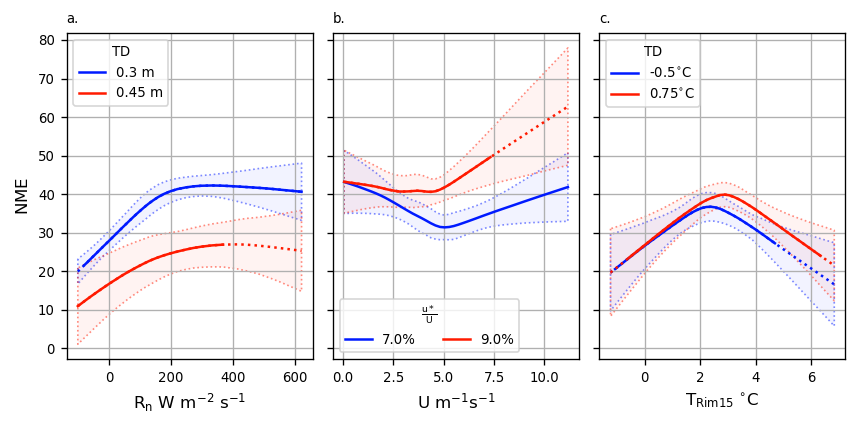

In [52]:
fig,ax = plt.subplots(1,3,figsize=(18.2*cm, 9.1*cm),sharey=True)

In [53]:
# # print(T30.loc[((T30['Active_Layer_1']>0)&(T30['Active_Layer_1']<=.33)&(np.isnan(T30['fch4'])==False)),['NR_Wm2_Avg']].quantile([0,.02,.5,.98,1]))
# # # print(T30.loc[((T30['VPD']>240)&(T30['VPD']<440)&(np.isnan(T30['fch4'])==False)),['NR_Wm2_Avg','Table_1']].quantile([0,.02,.5,.98,1]))
# # print(T30.loc[((T30['Active_Layer_1']<1)&(T30['Active_Layer_1']>=.4)&(np.isnan(T30['fch4'])==False)),['NR_Wm2_Avg']].quantile([0,.02,.5,.98,1]))
# # plt.figure()
# T30['Hour']=T30.index.hour
# Temp = T30[['Temp_15_1','Temp_15_2','DOY']].groupby('DOY').mean()
# plt.figure()
# plt.plot(Temp['Temp_15_1'].rolling(7).mean())
# plt.plot(Temp['Temp_15_2'].rolling(7).mean())


In [54]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland_/'  
FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
T30 = fch4.RST.Master.copy()
F = 'fch4'
N = 50
target = fch4
IP = target.Model_Selection.split('+')
print(IP)
for a in 'fch4','fco2':
    IP.append(a)
List = []
Name = 'Test'
Avars=['NR_Wm2_Avg']
# Avars=['Collapse']
A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
Bvars=['Active_Layer_1']
B = np.array([0.3,0.45])
# B = np.array([0.33])
C=[[],[],[],[]]
D=[[],[],[],[]]
Z=[[],[],[],[]]
V=[[],[],[],[]]

for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
    Temp = T30[IP].dropna()
    Av2,Bv2=np.meshgrid(A,B)
    Av2,Iv2=np.meshgrid(A,B)
    Iv = Iv2.flatten()
    Av,Bv=Av2.flatten(),Bv2.flatten()
    Temp = Temp[0:Av.shape[0]]*0+Temp.median()
    Temp[Avar]=Av
    Temp[Bvar]=Bv
    Temp['Class']=Iv
    for cvar in Cvar:
        A = T30[[Avar,cvar]].dropna()
        Lr = scipy.stats.linregress(A[Avar],A[cvar])
        print(Lr)
        Cv=(Av*Lr[0]+1)+Lr[1]
        Temp[cvar]=Cv
    for dvar in Dvar:
        A = T30[[Bvar,dvar]].dropna()
        Lr = scipy.stats.linregress(A[Bvar],A[dvar])
        print(Lr)
        Dv=Bv*Lr[0]+Lr[1]
        Temp[dvar]=Dv
    for z,v in zip(Zero,Val):
        Temp[z]=v
    Temp = Mapper(Temp,target,Name,Fill = False)
    List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])

l = 0
Rec = List[l][0]
A = List[l][1]
B = List[l][2]
i = 0
L = Rec['Class'].unique().shape[0]-1
if L == 0:
    L = 1
print(L)
for v in Rec['Class'].unique():
    Temp = Rec.loc[Rec['Class']==v]
    if v<= .33:
        TempA = Temp.loc[Temp[A]>-100]
        ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' m',color=[(L-(L-i))/L,.1,(L-i)/L])
    if v== .45:
        TempA = Temp.loc[Temp[A]<400]
        ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' m',color=[(L-(L-i))/L,.1,(L-i)/L])
    ax[0].fill_between(Temp[A],
        (Temp[Name]-Temp[Name+'_CI']), 
        (Temp[Name]+Temp[Name+'_CI']),
        facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
        edgecolor = [(L-(L-i))/L,.1,(L-i)/L,.5],
        linestyle=':',
        linewidth=1,
       )
    i +=1
ax[0].set_ylabel(r'$NME\ {nmol\ m^{-2}\ s^{-1}$')
ax[0].set_xlabel(r'$R_n\ W\ m^{-2}\ s^{-1}$')
ax[0].grid()
ax[0].legend(title='$TD$',loc='upper left')
ax[0].set_title('a.',loc='left')
# ax[0].tight_layout()
# ax[0].savefig(F+'_Plot.png'

['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Temp_15_2', 'Daytime']
fch4 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fch4/9_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

1


Text(0.0, 1.0, 'a.')

In [55]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
# FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
T30 = fch4.RST.Master.copy()
# F = 'fch4'
# N = 50
target = fch4
# IP = target.Model_Selection.split('+')
for a in 'fch4','fch4':
    IP.append(a)
List = []
Name = 'Test'
Avars=['wind_speed']
# A = np.array([T30[Avars].quantile(n/N) for n in range(N)])#[:-1]
A = np.linspace(T30[Avars].min(),T30[Avars].max(),N)
# A = np.array()
Bvars=['Active_Layer_1']
B = np.array([.3,.3])
Balt = np.array([0.07,0.09])
# Balt = np.array([0.08,0.08])
C=['u*',[],[],[]]
D=[[],[],[],[]]
Z=[[],[],[],[]]
V=[[],[],[],[]]

for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
    Temp = T30[IP].dropna()
    Av2,Bv2=np.meshgrid(A,B)
    Av2,Iv2=np.meshgrid(A,Balt)
    Iv = Iv2.flatten()
    Av,Bv=Av2.flatten(),Bv2.flatten()
    Temp = Temp[0:Av.shape[0]]*0+Temp.median()
    Temp[Avar]=Av
    Temp[Bvar]=Bv
    Temp[Cvar]=Av*Iv
    Temp['Class']=Iv#Bv#+Bv
    for dvar in Dvar:
        A = T30[[Bvar,dvar]].dropna()
        Lr = scipy.stats.linregress(A[Bvar],A[dvar])
        Dv=Bv*Lr[0]+Lr[1]
        Temp[dvar]=Dv
    for z,v in zip(Zero,Val):
        if len(v)>1:
            i = 0
            for c in Temp['Class'].unique():
                Temp.loc[Temp['Class']==c,z]=v[i]
                i+=1
        else:
            Temp[z]=v[0]
    Temp = Mapper(Temp,target,Name,Fill = False)
    List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
    
l = 0
Rec = List[l][0]
A = List[l][1]
B = List[l][2]
i = 0
L = Rec['Class'].unique().shape[0]-1
for v in Rec['Class'].unique():
    Temp = Rec.loc[Rec['Class']==v]
    if v == 0.09:
        TempA = Temp.loc[(Temp[A]<7.5)]
        ax[1].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[1].plot(TempA[A],TempA[Name],label=str(np.round(v*100,1))+'%',color=[(L-(L-i))/L,.1,(L-i)/L])
#     elif v == 0.08:
#         TempA = Temp.loc[(Temp[A]<7)]
#         ax[1].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
#         ax[1].plot(TempA[A],TempA[Name],label=str(np.round(v*100,1))+'%',color=[(L-(L-i))/L,.1,(L-i)/L])
    else:
        ax[1].plot(Temp[A],Temp[Name],label=str(np.round(v*100,1))+'%',color=[(L-(L-i))/L,.1,(L-i)/L])
    ax[1].fill_between(Temp[A],
        (Temp[Name]-Temp[Name+'_CI']), 
        (Temp[Name]+Temp[Name+'_CI']),
        facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
        edgecolor = [(L-(L-i))/L,.1,(L-i)/L,.5],
        linestyle=':',
        linewidth=1,
       )
    i +=1

ax[1].legend(title=r'$\frac{u*}{U}$',ncol=2,loc='lower left')
ax[1].set_xlabel('U $m^{-1}s^{-1}$')
ax[1].grid()
ax[1].set_title('b.',loc='left')

fch4 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fch4/9_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

Text(0.0, 1.0, 'b.')

In [56]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
T30 = fch4.RST.Master.copy()
F = 'fch4'
N = 50
target = fch4
IP = target.Model_Selection.split('+')
for a in 'fch4','fch4':
    IP.append(a)
List = []
Name = 'Test'
Avars=['Temp_15_2']
# A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
A = np.linspace(T30[Avars].min(),T30[Avars].max(),N)
Bvars=['Active_Layer_1']
B = np.array([.3,.3])
Balt = np.array([-0.5,0.75])
C=['Temp_15_1',[],[],[]]
D=[[],[],[],[]]
Z=[[],[],[],[]]
V=[[[]],[],[],[]]

for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
    Temp = T30[IP].dropna()
    Av2,Bv2=np.meshgrid(A,B)
    Av2,Iv2=np.meshgrid(A,Balt)
    Iv = Iv2.flatten()
    Av,Bv=Av2.flatten(),Bv2.flatten()
    Temp = Temp[0:Av.shape[0]]*0+Temp.median()
    Temp[Avar]=Av
    Temp[Bvar]=Bv
    Temp[Cvar]=Av-Iv
    Temp['Class']=Iv#Bv
    for dvar in Dvar:
        A = T30[[Bvar,dvar]].dropna()
        Lr = scipy.stats.linregress(A[Bvar],A[dvar])
        print(Lr)
        Dv=Bv*Lr[0]+Lr[1]
        Temp[dvar]=Dv
    for z,v in zip(Zero,Val):
#         print(z,v)
        if len(v)>1:
            i = 0
            for c in Temp['Class'].unique():
                Temp.loc[Temp['Class']==c,z]=v[i]
#                 print(Temp.loc[Temp['Class']==c,z])
                i+=1
        else:
            Temp[z]=v[0]
#     print(Temp)
    Temp = Mapper(Temp,target,Name,Fill = False)
    List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
l = 0
Rec = List[l][0]
A = List[l][1]
B = List[l][2]
i = 0
L = Rec['Class'].unique().shape[0]-1
for v in Rec['Class'].unique():
    Temp = Rec.loc[Rec['Class']==v]
    print(v)
    if v == Balt[0]:
        TempA = Temp.loc[((Temp[A]>-1.225)&(Temp[A]<4.826))]
        ax[2].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[2].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'$^{\circ}$C',color=[(L-(L-i))/L,.1,(L-i)/L])
    else:
        TempA = Temp.loc[((Temp[A]>-0.603)&(Temp[A]<6.450))]
        ax[2].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[2].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'$^{\circ}$C',
                 color=[(L-(L-i))/L,.1,(L-i)/L])
    ax[2].fill_between(Temp[A],
        (Temp[Name]-Temp[Name+'_CI']), 
        (Temp[Name]+Temp[Name+'_CI']),
        facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
        edgecolor = [(L-(L-i))/L,.1,(L-i)/L,.5],
        linestyle=':',
        linewidth=1,
       )
    i +=1
ax[2].set_xlabel(r'$T_{Rim15}$ $^{\circ}$C')
ax[2].legend(title='$TD$',loc='upper left')
ax[2].grid()
ax[2].set_title('c.',loc='left')
plt.tight_layout()
plt.savefig(F+'_Plot.jpg',dpi=600)

fch4 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fch4/9_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

-0.5
0.75


<IPython.core.display.Javascript object>


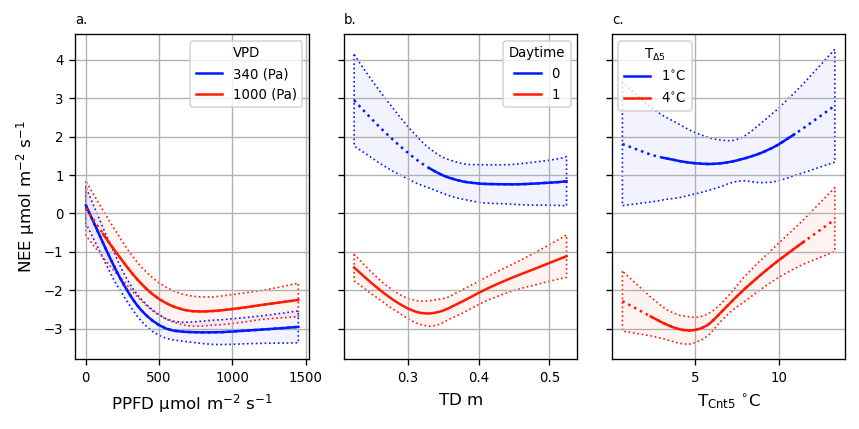

In [64]:
fig,ax = plt.subplots(1,3,figsize=(18.2*cm, 9.1*cm),sharey=True)

In [65]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
T30 = fco2.RST.Master.copy()
F = 'fco2'
N = 50
target = fco2
IP = target.Model_Selection.split('+')
print(IP)
for a in 'fch4','fco2':
    IP.append(a)
List = []
Name = 'Test'
Avars=['PPFD_Avg']
A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
Bvars=['VPD']
B = np.array([340,1000])
C=[['NR_Wm2_Avg'],[],[],[]]
D=[[],[],[],[]]
Z=[['Daytime'],[],[],[]]
V=[[1],[],[],[]]

for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
    Temp = T30[IP].dropna()
    Av2,Bv2=np.meshgrid(A,B)
    Av2,Iv2=np.meshgrid(A,B)
    Iv = Iv2.flatten()
    Av,Bv=Av2.flatten(),Bv2.flatten()
    Temp = Temp[0:Av.shape[0]]*0+Temp.median()
    Temp[Avar]=Av
    Temp[Bvar]=Bv
    Temp['Class']=Iv
    for cvar in Cvar:
        A = T30[[Avar,cvar]].dropna()
        Lr = scipy.stats.linregress(A[Avar],A[cvar])
        print(Lr)
        Cv=(Av*Lr[0]+1)+Lr[1]
        Temp[cvar]=Cv
    for dvar in Dvar:
        A = T30[[Bvar,dvar]].dropna()
        Lr = scipy.stats.linregress(A[Bvar],A[dvar])
        print(Lr)
        Dv=Bv*Lr[0]+Lr[1]
        Temp[dvar]=Dv
    for z,v in zip(Zero,Val):
        Temp[z]=v
    Temp = Mapper(Temp,target,Name,Fill = False)
    List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
l = 0
Rec = List[l][0]
A = List[l][1]
B = List[l][2]
i = 0
L = Rec['Class'].unique().shape[0]-1
for v in Rec['Class'].unique():
    Temp = Rec.loc[Rec['Class']==v]
    if v== 50:
        TempA = Temp.loc[Temp[A]<635]
        ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' (Pa)',color=[(L-(L-i))/L,.1,(L-i)/L])
    elif v == 340:
        TempA = Temp.loc[Temp[A]>0]
        ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' (Pa)',color=[(L-(L-i))/L,.1,(L-i)/L])
    elif v == 1000:
        TempA = Temp.loc[Temp[A]>116]
        ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' (Pa)',color=[(L-(L-i))/L,.1,(L-i)/L])
    ax[0].fill_between(Temp[A],
                (Temp[Name]-Temp[Name+'_CI']), 
                (Temp[Name]+Temp[Name+'_CI']),
                facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
                edgecolor = [(L-(L-i))/L,.1,(L-i)/L],
                linestyle=':',
                linewidth=1,
               )
    i +=1
ax[0].set_ylabel(r'$NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[0].set_xlabel(r'$PPFD\  {\mu}mol\ m^{-2}\ s^{-1}$')
ax[0].legend(title='VPD')
ax[0].grid()
ax[0].set_title('a.',loc='left')
# ax[0].tight_layout()
# ax[0].savefig(F+'_Plot.png')

['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime']
LinregressResult(slope=0.43050535487346825, intercept=-34.73166067602388, rvalue=0.980928476873282, pvalue=0.0, stderr=0.001356422729030322)
fco2 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fco2/10_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

Text(0.0, 1.0, 'a.')

In [66]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
T30 = fco2.RST.Master.copy()
F = 'fco2'
N = 50
target = fco2
IP = target.Model_Selection.split('+')
print(IP)
for a in 'fch4','fco2':
    IP.append(a)
List = []
Name = 'Test'
Avars=['Active_Layer_1']
A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
Bvars=['Daytime']
B = np.array([0,1])
C=[[],[],[],[]]
D=[['PPFD_Avg','NR_Wm2_Avg'],[],[]]
Z=[[],[],[],[]]
V=[[],[],[],[]]

for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
    Temp = T30[IP].dropna()
    Av2,Bv2=np.meshgrid(A,B)
    Av2,Iv2=np.meshgrid(A,B)
    Iv = Iv2.flatten()
    Av,Bv=Av2.flatten(),Bv2.flatten()
    Temp = Temp[0:Av.shape[0]]*0+Temp.median()
    Temp[Avar]=Av
    Temp[Bvar]=Bv
    Temp['Class']=Iv
    for cvar in Cvar:
        A = T30[[Avar,cvar]].dropna()
        Lr = scipy.stats.linregress(A[Avar],A[cvar])
        print(Lr)
        Cv=(Av*Lr[0]+1)+Lr[1]
        Temp[cvar]=Cv
    for dvar in Dvar:
        A = T30[[Bvar,dvar]].dropna()
        Lr = scipy.stats.linregress(A[Bvar],A[dvar])
        print(Lr)
        Dv=Bv*Lr[0]+Lr[1]
#         print(Dv)
        Temp[dvar]=Dv
    for z,v in zip(Zero,Val):
        Temp[z]=v
    Temp = Mapper(Temp,target,Name,Fill = False)
    List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
l = 0
Rec = List[l][0]
A = List[l][1]
B = List[l][2]
i = 0
L = Rec['Class'].unique().shape[0]-1
for v in Rec['Class'].unique():
    Temp = Rec.loc[Rec['Class']==v]
    if v== 0:
        TempA = Temp.loc[Temp[A]>.33]
        ax[1].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[1].plot(TempA[A],TempA[Name],label=str(np.round(v,2)),color=[(L-(L-i))/L,.1,(L-i)/L])
    else:
        ax[1].plot(Temp[A],Temp[Name],label=str(np.round(v,2)),color=[(L-(L-i))/L,.1,(L-i)/L])
    ax[1].fill_between(Temp[A],
                (Temp[Name]-Temp[Name+'_CI']), 
                (Temp[Name]+Temp[Name+'_CI']),
                facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
                edgecolor = [(L-(L-i))/L,.1,(L-i)/L],
                linestyle=':',
                linewidth=1,
               )
    i +=1
# ax[1].set_ylabel(r'$NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[1].set_xlabel(r'$TD$ m')
ax[1].legend(title='Daytime')
ax[1].grid()
ax[1].set_title('b.',loc='left')
# ax[1].tight_layout()
# ax[1].savefig(F+'_Plot.png')

['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime']
LinregressResult(slope=380.2184076653013, intercept=0.9402510121460068, rvalue=0.3184385079824251, pvalue=5.942701292199205e-94, stderr=17.9976903876629)
LinregressResult(slope=159.60348567680765, intercept=-30.753979757084878, rvalue=0.30457454094667336, pvalue=1.0206106623501604e-85, stderr=7.936614243808544)
fco2 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fco2/10_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

Text(0.0, 1.0, 'b.')

In [67]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
T30 = fco2.RST.Master.copy()
F = 'fco2'
N = 50
target = fco2
IP = target.Model_Selection.split('+')
for a in 'fch4','fco2':
    IP.append(a)
List = []
Name = 'Test'
Avars=['Temp_5_1']
A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
Bvars=['Temp_15_2']
B = np.array([4.7,2.5])
Balt = np.array([1,4])
C=['Temp_5_2',[],[],[]]
D=[[],[],[],[]]
Z=[['Daytime','PPFD_Avg','NR_Wm2_Avg'],[],[],[]]
V=[[[0,1],[0,381],[-30,128]],[],[],[]]

for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
    Temp = T30[IP].dropna()
    Av2,Bv2=np.meshgrid(A,B)
    Av2,Iv2=np.meshgrid(A,Balt)
    Iv = Iv2.flatten()
    Av,Bv=Av2.flatten(),Bv2.flatten()
    Temp = Temp[0:Av.shape[0]]*0+Temp.median()
    Temp[Avar]=Av
    Temp[Bvar]=Bv
    Temp[Cvar]=Av+Iv
    Temp['Class']=Iv
    for dvar in Dvar:
        A = T30[[Bvar,dvar]].dropna()
        Lr = scipy.stats.linregress(A[Bvar],A[dvar])
        print(Lr)
        Dv=Bv*Lr[0]+Lr[1]
        Temp[dvar]=Dv
    for z,v in zip(Zero,Val):
#         print(z,v)
        if len(v)>1:
            i = 0
            for c in Temp['Class'].unique():
                Temp.loc[Temp['Class']==c,z]=v[i]
#                 print(Temp.loc[Temp['Class']==c,z])
                i+=1
        else:
            Temp[z]=v[0]
#     print(Temp)
    Temp = Mapper(Temp,target,Name,Fill = False)
    List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
l = 0
Rec = List[l][0]
A = List[l][1]
B = List[l][2]
i = 0
L = Rec['Class'].unique().shape[0]-1
for v in Rec['Class'].unique():
    Temp = Rec.loc[Rec['Class']==v]
    print(v)
    if v == Balt[0]:
        TempA = Temp.loc[((Temp[A]>2.99)&(Temp[A]<11.1))]
        ax[2].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[2].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'$^{\circ}$C',color=[(L-(L-i))/L,.1,(L-i)/L])
    else:
        TempA = Temp.loc[((Temp[A]>1.25)&(Temp[A]<13.2))]
        ax[2].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        ax[2].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'$^{\circ}$C',color=[(L-(L-i))/L,.1,(L-i)/L])
    ax[2].fill_between(Temp[A],
        (Temp[Name]-Temp[Name+'_CI']), 
        (Temp[Name]+Temp[Name+'_CI']),
        facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
        edgecolor = [(L-(L-i))/L,.1,(L-i)/L],
        linestyle=':',
        linewidth=1,
       )
    i +=1
# ax[2].set_ylabel(r'$NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[2].set_xlabel(r'$T_{Cnt5}$ $^{\circ}$C')
ax[2].legend(title='$T_{\Delta5}$',loc=2)
ax[2].grid()
ax[2].set_title('c.',loc='left')
plt.tight_layout()
plt.savefig(F+'_Plot.jpg',dpi=600)

fco2 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fco2/10_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

1
4


# Gap filling etc!

In [8]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland_Paper/'  
FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName='AllData.csv',Site=Site,FPVars=FPVars)
ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName='AllData.csv',Site=Site,AltPath='fco2',FPVars=FPVars)
T30 = fco2.RST.Master.copy()
# print(T30['ER'].describe())[]
# plt.figure()

In [9]:

mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }
T30 = Mapper(T30,fch4,'NME_est',Fill = False)
T30 = Mapper(T30,fco2,'NEE_est',Fill = False)

T30_Dark = T30.copy()
T30_Dark['PPFD_Avg'] = 0
T30_Dark['Daytime'] = 0
T30_Dark.loc[T30_Dark['NR_Wm2_Avg']>0,'NR_Wm2_Avg'] = 0#T30['NR_Wm2_Avg'].min()

T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)

fch4 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fch4/9_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

fco2 ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fco2/10_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

ER ['VPD', 'u*', 'wind_speed', 'NR_Wm2_Avg', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland_Paper//fco2/10_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

In [10]:
for target,name in zip([fch4,fco2,ER],['NME','NEE','ER']):
    target.cols = []
    print(name)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,ER],['NME_est','NEE_est','ER_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')
print(T30['ER_est'].mean())
print(T30['NEE_est'].mean())
print(T30['ER'].mean())
print(T30['NEE'].mean())
T30['GPP_est'] = T30['ER_est'] - T30['NEE_est']
T30['GPP'] = T30['ER'] - T30['NEE']

NME
NEE
ER
Done
Done
1.537334680557251
-0.6063271760940552
1.5362354506005718
-0.6048875740196669


In [11]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)

Temp = T30.copy()
Estimates = []
CIs = []
SE = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
           'NME':fch4,
           'NEE_est':fco2,
           'NME_est':fch4,
           'ER_est':ER,
           'ER':ER}
for Var in ['NEE',
            'NME',
            'ER']:#,
    target = Targets[Var]
    if Var == 'NEE' or Var == 'NME' or Var == 'ER':
        CIPI = 'CI'
        Fluxes.append(Var.split('_')[0])
        Type.append('EC Obs.')
        std = MI(Temp,target.cols)**.5*1*mult[target.target]
#         print((std/Temp.shape[0]**.5)*1*mult[target.target]*stats.t.ppf(1-.025,Temp[Var].count()))
        Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())

    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'CI'
        Type.append('EC Obs.')
        std = (Temp[Var+'_Var_reg']).mean()**.5*mult[target.target]*1
        Int=((std)/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
    SE.append(std)

    U = Temp[Var].sum()/(Temp.shape[0]/1)#*mult[target.target]
    print(Temp[Var].sum(),(Temp.shape[0]/1),U)
    print()
#     if target == 'ER':
#         U*= mult[target.target]
    Estimates.append(U)
    CIs.append(Int)

    Scale.append('Footprint')
    
    Samples.append(Temp[Var].count())
    IntType.append(CIPI)
    
std = MI(Temp,Cols)**.5
Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
print(Temp['CBal'].mean()*1,Int*1)
    
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}

print(Estimates[0]+Estimates[1])

All = pd.DataFrame(data = Data)

print((All['Estimates'].iloc[0]-All['Estimates'].iloc[2])*-1)

All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]

-2396.5645682659174 3962.0 -0.6048875740196662

107994.41772431241 3962.0 27.25755116716618

6086.56485527945 3962.0 1.536235450600568

26.652663593146492 0.3557425138332015
26.652663593146514
2.141123024620234


,Flux,Type,Scale,Estimates,SE,95% CI/PI
0,NEE,EC Obs.,Footprint,-0.604888,1.421679,0.044282
1,NME,EC Obs.,Footprint,27.257551,11.705688,0.364603
2,ER,EC Obs.,Footprint,1.536235,0.912356,0.028418


In [12]:
mult = {'fco2-c':(1e-6 * 12.0107 *3600),
        'fco2':(1e-6 * 44.0107 *3600),
#         'ER':(1e-6 * 12.0107 *1800),
        'fch4-c':(1e-6 * 12.0107 *3600),
        'fch4':(1e-6 * 16.04 *3600)}
print(T30.loc[T30.index.month==6,'NME'].mean())
print(T30.loc[T30.index.month==7,'NME'].mean())
print(T30.loc[T30.index.month==8,'NME'].mean())
print(T30.loc[T30.index.month==9,'NME'].mean())


print(T30.loc[((T30.index>='2017-07-11')&(T30.index<='2017-08-07')),['NEE','ER','NME']].mean()*mult['fco2-c']*24)

# print(4.3/mult['fch4'])
# print(12.5/mult['fch4'])



34.114216800130784
35.09707286224911
22.80816304612879
14.50426485281737
NEE    -1.018841
ER      1.703118
NME    34.561756
dtype: float64


<IPython.core.display.Javascript object>


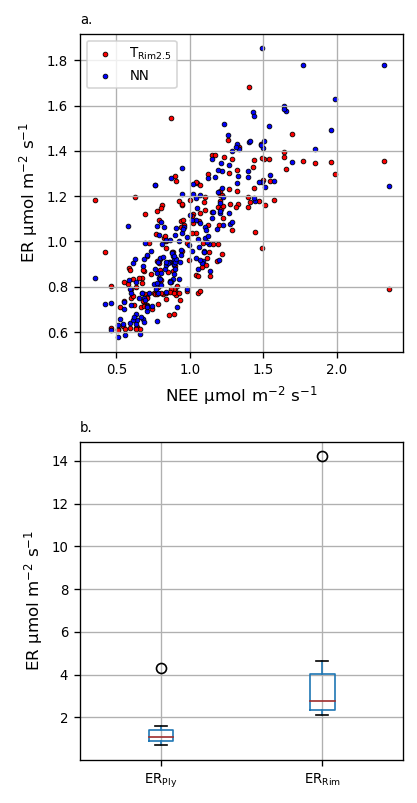

Temp_2_5_2 0.45654962152301815    0.25626772302773265
AirTC 0.32011942379866976    0.28663569946758544
0.7064637416777436 0.1883409858634397
186


In [13]:

fig,ax=plt.subplots(2,1,figsize = (8.84*cm,17*cm))#,sharey=True)

# Night = T30.loc[T30['Daytime']==0].copy()
# Night['Position'] = 3
# Day = T30.loc[T30['Daytime']==1].copy()
# Day['Position'] = 4
# Day['Flux'] = Day['ER']

class ChamberAnalysis:
    def __init__(self,ChamberPath,flux):
        self.Data = pd.read_csv(ChamberPath,delimiter = ',')
        self.Data.loc[self.Data['Position']==3,'Position']=1
ChamberPath = 'C:\\FishIsland_2017\\ChamberStationData/ChamberFluxes.csv'
flux = 'CO2 Flux (umol/m2/s)'


CH = ChamberAnalysis(ChamberPath,flux)
Data = CH.Data[['Position','Flux']].copy()
    
bp0 = Data.boxplot(by='Position',ax=ax[1],return_type='dict')

[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
ax[1].set_title(None)
ax[1].set_title('b.',loc='left')
# ax[1].set_ylabel('${u}mol m^{-2} s^{-1}$')

ax[1].set_ylabel(r'$ER\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[1].set_xticklabels(['$ER_{Ply}$','$ER_{Rim}$'])#,'Daytime ER'])
ax[1].set_xlabel(None)
# ax
fig.suptitle(None)


Dark = T30.loc[T30['Daytime']==0,['co2_flux','ER_est','AirTC_Avg',
                                  'Temp_2_5_2','Temp_2_5_1','Temp_5_2','Temp_5_1','Temp_15_2','Temp_15_1']].dropna()

def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))

for Temp in ['Temp_2_5_1','Temp_5_2','Temp_5_1','Temp_15_2','Temp_15_1','Temp_2_5_2']:
#     print(Temp)
    popt_r, pcov = curve_fit(R_func, Dark[Temp], Dark['co2_flux'])
    R = metrics.r2_score(Dark['co2_flux'],R_func(Dark[Temp],*popt_r))
    if Temp == 'Temp_2_5_2':
        ax[0].scatter(Dark['co2_flux'],R_func(Dark[Temp],*popt_r),c='red',edgecolor='k',linewidth=.5,s=8,
                    label='$T_{Rim2.5}$')


popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['co2_flux'])
print(Temp,R,
  '  ',metrics.mean_squared_error(Dark['co2_flux'],R_func(Dark['Temp_2_5_2'],*popt_r))**.5)
print('AirTC' , metrics.r2_score(Dark['co2_flux'],R_func2(Dark['AirTC_Avg'],*popt_r2)),
      '  ',metrics.mean_squared_error(Dark['co2_flux'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
ax[0].scatter(Dark['co2_flux'],Dark['ER_est'],c='blue',edgecolor='k',linewidth=.5,s=8,
            label='NN')


print(metrics.r2_score(Dark['co2_flux'],Dark['ER_est']),metrics.mean_squared_error(Dark['co2_flux'],Dark['ER_est'])**.5)
ax[0].legend()
ax[0].set_xlabel(r'$NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[0].set_ylabel(r'$ER\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[0].grid()

ax[0].set_title('a.',loc='left')
print(Dark['co2_flux'].count())
plt.tight_layout()
plt.savefig('ER.jpg',dpi = 600)

In [14]:
# ax[1].figure()
print(Data.groupby('Position').median())


C2 =((T30['Collapse']*1.092802).mean())
C3 =((T30['Collapse']*2.774963).mean())


C4 =((T30['FarField']*(.33*2.774963+.67*1.092802)).mean())

C5 =((T30['FarField']*(.37*2.774963+.63*1.092802)).mean())


C1 = ((T30['Polygon']*1.092802).mean())+((T30['Rim']*2.774963).mean())

print(C1 + C2 + C4)
print(C1 + C3 + C5)
print(T30.loc[((T30['Daytime']==1)&(T30.index.month<=7)&(T30.PPFD_Avg<=10)),'PPFD_Avg'].dropna().sort_values())

              Flux
Position          
1         1.092802
2         2.774963
1.5412033715846252
1.603988909861889
datetime
2017-07-27 05:00:00-06:00    0.324
2017-07-27 04:30:00-06:00    0.338
2017-07-27 04:00:00-06:00    0.354
2017-07-27 05:30:00-06:00    0.664
2017-07-30 01:30:00-06:00    0.962
2017-07-21 03:00:00-06:00    1.784
2017-07-21 02:30:00-06:00    2.013
2017-07-21 03:30:00-06:00    2.034
2017-07-27 06:00:00-06:00    2.037
2017-07-21 04:30:00-06:00    2.054
2017-07-26 03:30:00-06:00    2.068
2017-07-25 03:30:00-06:00    2.248
2017-07-31 04:30:00-06:00    3.210
2017-07-26 04:00:00-06:00    3.237
2017-07-21 04:00:00-06:00    3.622
2017-07-31 01:30:00-06:00    3.830
2017-07-25 02:30:00-06:00    3.946
2017-07-21 00:30:00-06:00    4.520
2017-06-23 03:30:00-06:00    4.655
2017-07-24 04:30:00-06:00    4.660
2017-07-24 02:00:00-06:00    4.666
2017-07-24 05:30:00-06:00    4.673
2017-07-24 05:00:00-06:00    4.673
2017-07-29 04:00:00-06:00    4.673
2017-07-24 03:30:00-06:00    4.673
201

<IPython.core.display.Javascript object>


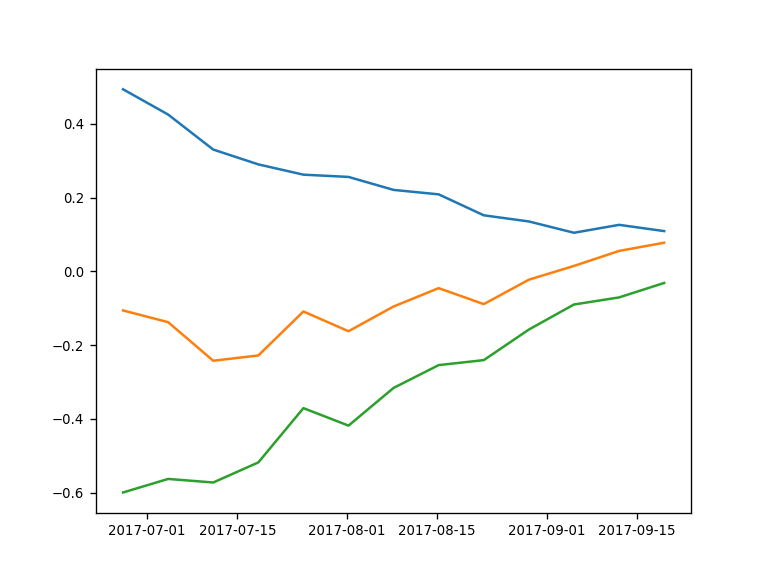

2501
186


In [15]:
plt.figure()
plt.plot(T30['ER_est'].resample('W-Tue').mean()*mult['fco2']*1)
plt.plot(T30['NEE_est'].resample('W-Tue').mean()*mult['fco2']*1)
plt.plot(T30['NEE_est'].resample('W-Tue').mean()*mult['fco2']*1-T30['ER_est'].resample('W-Tue').mean()*mult['fco2']*1)
print(T30['fco2'].count())
print(T30.loc[T30['Daytime']==0,'fco2'].count())

# print(T30[['fch4','Collapse']].count())

<IPython.core.display.Javascript object>


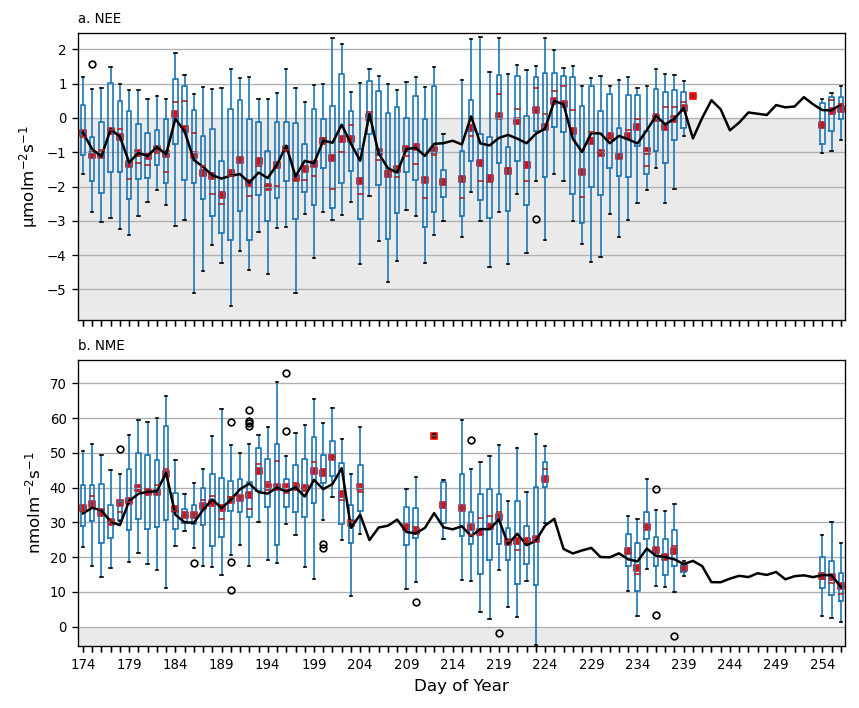

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0',
       '11.0', '12.0'],
      dtype='object', name='Week')


In [16]:

T30['Hour']=T30.index.hour-3
T30.loc[T30['Hour']<0,'Hour']+=24

cm = 1/2.54  # centimeters in inches
# plt.subplots(figsize=(15*cm, 5*cm))

fig,ax = plt.subplots(2,1,sharex=True,figsize=(18.2*cm, 15*cm))
medianprops = dict(linestyle='-', linewidth=1, color='k')
T30['ch4_flux_scaled']=T30['ch4_flux']*1e3

Agg = 'DOY'

T30['Week'] = np.floor(((T30.index.dayofyear - T30.index.dayofyear[0])/7))+1
# T30['Week_Raw'] = ((T30.index.dayofyear - T30.index.dayofyear[0])/7)

T30['DOW'] = T30.index.dayofweek
# Wk = T30['Week'].resample('Week')
First = T30[['Week']].reset_index().groupby('Week').first()
Last = T30[['Week']].reset_index().groupby('Week').last()
print(First.index.astype(str))
Xlbls = ('Week '+First.index.astype(int).astype(str)+'\n'+First['datetime'].dt.dayofyear.astype(str)+ '-'+Last['datetime'].dt.dayofyear.astype(str))
# Idx = T30['Week].

flierprops = dict(markersize=4)

bp0=T30[['co2_flux',Agg]].boxplot(by=Agg,ax=ax[0],medianprops = medianprops,flierprops=flierprops, return_type='dict')
bp1=T30[['ch4_flux_scaled',Agg]].boxplot(by=Agg,ax=ax[1],medianprops = medianprops,flierprops=flierprops, return_type='dict')



[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
Week = T30.groupby(Agg).mean()
WeekC = T30.groupby(Agg).count()
XT = ax[0].get_xticks()[0:Week.shape[0]]
a1=((Week['NEE'].max()-Week['NEE'].min())/mult['fco2'])
b1=((Week['NME'].max()-Week['NME'].min())/mult['fch4'])
ax[0].scatter(XT,Week['co2_flux'], color='r',s=10,marker='s')
ax[1].scatter(XT,Week['ch4_flux']*1e3, color='r',s=10,marker='s')
# ax02 = ax[0].twinx()
# ax12 = ax[1].twinx()
# ax02.plot(XT,WeekC['co2_flux']/WeekC['Hour'],color='k',linestyle=':')
# ax12.plot(XT,WeekC['ch4_flux']/WeekC['Hour'],color='k',linestyle=':')

# ax[0].set_zorder(ax02.get_zorder()+1)
ax[0].patch.set_visible(False)
# ax[1].set_zorder(ax12.get_zorder()+1)
ax[1].patch.set_visible(False)
# ax02.set_ylim(0,1)
# ax12.set_ylim(0,1)
# ax02.set_ylabel('Data Coverage %')
# ax12.set_ylabel('Data Coverage %')

# print(Temp['ch4_flux'].count()/Temp['NME'].count())
ax[0].plot(XT,Week['NEE'],color='k')
# ax[0].plot(XT,Week['ER']/mult['fco2'],color='k',linestyle='-.')
# ax[0].plot(XT,-Week['GPP']/mult['fco2'],color='k',linestyle=':')
ax[1].plot(XT,Week['NME'],color='k')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
yl1 = [T30['co2_flux'].min()+T30['co2_flux'].min()*.075,T30['co2_flux'].max()+T30['co2_flux'].max()*.05]#ax[0].get_ylim()
ax[0].axhspan(yl1[0],0, facecolor='0.2', alpha=0.1)
yl2 = [T30['ch4_flux'].min()*1e3+T30['ch4_flux'].min()*1e3*.075,T30['ch4_flux'].max()*1e3+T30['ch4_flux'].max()*1e3*.05]#ax[1].get_ylim()
ax[1].axhspan(yl2[0],0, facecolor='0.2', alpha=0.1)
# ax2 = ax[1].twinx()
# ax2.plot(Week['Table_1'])

# ax[1].set_ylim(yl2[0],yl2[1])
ax[0].set_title('')
ax[1].set_title('')

ax[0].set_title('a. NEE',loc='left')
ax[1].set_title('b. NME',loc='left')
ax[0].set_xlabel('')
ax[1].set_xlabel('Day of Year')
ax[0].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[1].set_ylabel('$nmol m^{-2} s^{-1}$')

ax[0].set_ylim(yl1[0],yl1[1])
ax[1].set_ylim(yl2[0],yl2[1])


if Agg == 'Week':
    ax[1].set_xticklabels(Xlbls,rotation =45)
# ax[1].set_xticsk
# print(XT)
else:
    for i,label in enumerate(ax[1].xaxis.get_ticklabels()):
        if math.remainder(i,5) != 0:
            label.set_visible(False)
        
plt.suptitle('')
plt.tight_layout()
plt.savefig('Daily.jpg',dpi = 600)


<IPython.core.display.Javascript object>


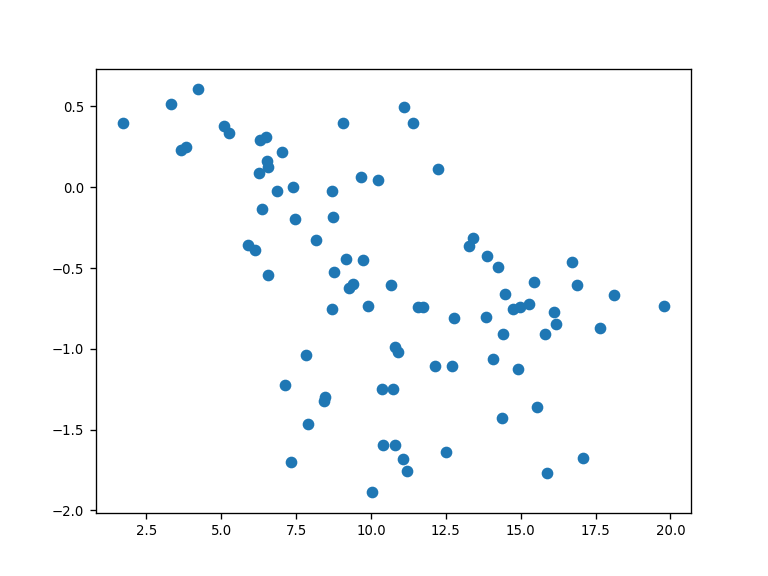

In [17]:
# plt.figure(figsize=(6,5))
# sel = Week.loc[Week.NEE<Week['NEE'].quantile(.15)]
# plt.bar(Week.index,Week.NEE)
# plt.bar(sel.index,sel.NEE)
# print(sel.index.min(),sel.index.max())

# print(T30.loc[T30.DOY==sel.index.min()].index[0])
# print(Week.loc[Week.NEE==Week['NEE'].min()].index[0])
# print(T30.loc[T30.DOY==sel.index.max()].index[-1])
# print()
# plt.figure(figsize=(6,5))
# sel = Week.loc[Week.NME>Week['NME'].quantile(.85)]
# plt.bar(Week.index,Week.NME)
# plt.bar(sel.index,sel.NME)
# print(sel.index.min(),sel.index.max())
# print(T30.loc[T30.DOY==sel.index.min()].index[0])
# # print(Week.loc[Week.NME==Week['NME'].max()].index.dayofyear[0])
# print(Week.loc[Week.NME==Week['NME'].max()].index[0])
# print(T30.loc[T30.DOY==sel.index.max()].index[-1])
plt.figure()
plt.scatter(Week['AirTC_Avg'],Week['NEE'])

<IPython.core.display.Javascript object>


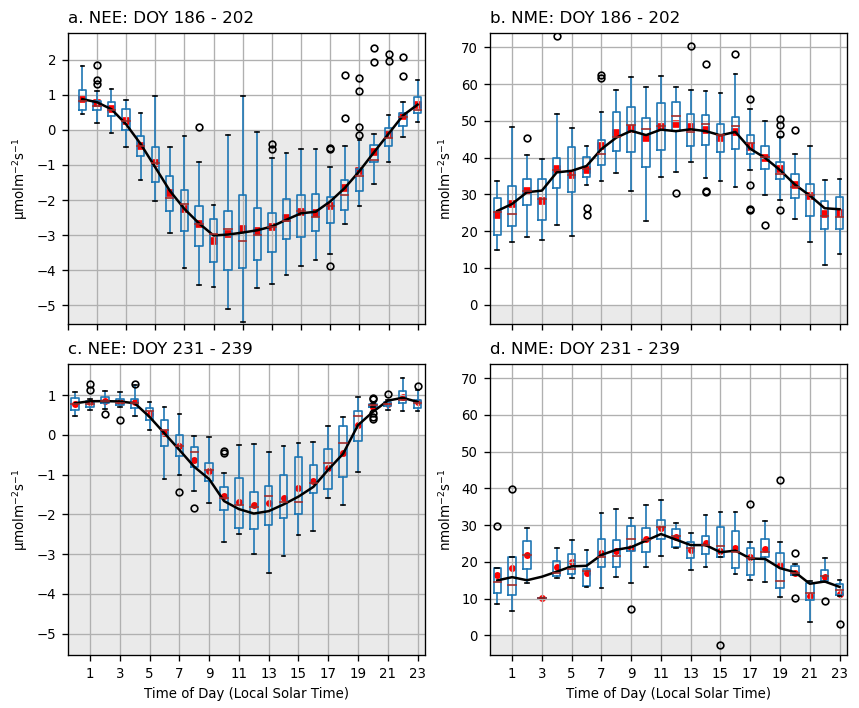

18
19.543764705882353
Model
mean:  -1.3333402769196823 38.431118410208796
max:  0.8754304237776952 47.72194244352812
min:  -3.008984641573513 25.51196009799434
Obs
mean:  -1.3386375576025131 38.31082782941317
max:  0.886284101769231 49.1625904
min:  -3.159551254375 24.339520937499998
Peak
[9]
[13]
Min
[0]
[0]
9
Model
mean:  -0.31640212863133005 19.955611500227665
max:  0.9341594296336326 27.56246093979334
min:  -1.9789632466716691 13.173836476401576
Obs
mean:  -0.23636071120817745 20.32787667175926
max:  0.9499816415833334 29.0982177
min:  -1.7670561641538463 10.130780000000001
Peak
[12]
[11]
Min
[22]
[23]
12
5.444444444444442


In [22]:

fig,ax = plt.subplots(2,2,sharex=True,figsize=(18.2*cm, 15*cm))
medianprops = dict(linestyle='-', linewidth=1, color='k')
T30['ch4_flux_scaled']=T30['ch4_flux']*1e3

flierprops = dict(markersize=4)
Temp = T30.loc[((T30.DOY>=186) & (T30.DOY<=202))]
# Temp = T30.loc[T30.Month==7]
bp0=Temp[['co2_flux','Hour']].boxplot(by='Hour',ax=ax[0,0],medianprops = medianprops,flierprops=flierprops, return_type='dict')
bp1=Temp[['ch4_flux_scaled','Hour']].boxplot(by='Hour',ax=ax[0,1],medianprops = medianprops,flierprops=flierprops, return_type='dict')


[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
Hour = Temp.groupby('Hour').mean()

a1=((Hour['NEE'].max()-Hour['NEE'].min())/mult['fco2'])
b1=((Hour['NME'].max()-Hour['NME'].min())/mult['fch4'])

print(Hour.loc[Hour['NEE']<0].count()['NEE'])
print(Hour.PPFD_Avg.min())

print('Model')
print('mean: ',Hour['NEE'].mean(),Hour['NME'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['NEE'].max(),Hour['NME'].max())#/mult['fco2']*1e3)
print('min: ',Hour['NEE'].min(),Hour['NME'].min())#/mult['fco2']*1e3)
print('Obs')
print('mean: ',Hour['fco2'].mean(),Hour['fch4'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['fco2'].max(),Hour['fch4'].max())#/mult['fco2']*1e3)
print('min: ',Hour['fco2'].min(),Hour['fch4'].min())#/mult['fco2']*1e3)
print('Peak')
print(Hour.loc[Hour['NEE']==Hour['NEE'].min()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].max()].index.values)
print('Min')
print(Hour.loc[Hour['NEE']==Hour['NEE'].max()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].min()].index.values)

ax[0,0].scatter(Hour.index+1,Hour['co2_flux'], color='r',s=10,marker='s')
ax[0,1].scatter(Hour.index+1,Hour['ch4_flux']*1e3, color='r',s=10,marker='s')
ax[0,0].plot(Hour.index+1,Hour['NEE'],color='k')
ax[0,1].plot(Hour.index+1,Hour['NME'],color='k')

yl1 = [T30['co2_flux'].min()+T30['co2_flux'].min()*.01,T30['co2_flux'].max()+T30['co2_flux'].max()*.01]#ax[0,0].get_ylim()
ax[0,0].axhspan(yl1[0],0, facecolor='0.2', alpha=0.1)
ax[0,0].set_ylim(yl1[0],2.75)#yl1[1])
yl2 = [T30['ch4_flux'].min()*1e3+T30['ch4_flux'].min()*1e3*.01,T30['ch4_flux'].max()*1e3+T30['ch4_flux'].max()*1e3*.01]#ax[0,1].get_ylim()
ax[0,1].axhspan(yl2[0],0, facecolor='0.2', alpha=0.1)
ax[0,1].set_ylim(yl2[0],yl2[1])
ax[0,0].set_title('')
ax[0,1].set_title('')
ax[0,0].set_title('a. NEE: DOY 186 - 202',loc='left')
ax[0,1].set_title('b. NME: DOY 186 - 202',loc='left')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,0].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[0,1].set_ylabel('$nmol m^{-2} s^{-1}$')


# Temp = T30.loc[((T30.DOY>=230) & (T30.DOY<=243))]
Temp = T30.loc[((T30.DOY>=231) & (T30.DOY<=239))]
print(Temp.resample('D').mean()['NEE'].count())

bp0=Temp[['co2_flux','Hour']].boxplot(by='Hour',ax=ax[1,0],medianprops = medianprops,flierprops=flierprops,return_type='dict')
bp1=Temp[['ch4_flux_scaled','Hour']].boxplot(by='Hour',ax=ax[1,1],medianprops = medianprops,flierprops=flierprops,return_type='dict')
[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
Hour = Temp.groupby('Hour').mean()
a2=((Hour['NEE'].max()-Hour['NEE'].min())/mult['fco2'])
b2=((Hour['NME'].max()-Hour['NME'].min())/mult['fch4'])

print('Model')
print('mean: ',Hour['NEE'].mean(),Hour['NME'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['NEE'].max(),Hour['NME'].max())#/mult['fco2']*1e3)
print('min: ',Hour['NEE'].min(),Hour['NME'].min())#/mult['fco2']*1e3)
print('Obs')
print('mean: ',Hour['fco2'].mean(),Hour['fch4'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['fco2'].max(),Hour['fch4'].max())#/mult['fco2']*1e3)
print('min: ',Hour['fco2'].min(),Hour['fch4'].min())#/mult['fco2']*1e3)
print('Peak')
print(Hour.loc[Hour['NEE']==Hour['NEE'].min()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].max()].index.values)
print('Min')
print(Hour.loc[Hour['NEE']==Hour['NEE'].max()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].min()].index.values)
print(Hour.loc[Hour['NEE']>0].count()['NEE'])

ax[1,0].scatter(Hour.index+1,Hour['co2_flux'], color='r',s=10)
ax[1,1].scatter(Hour.index+1,Hour['ch4_flux']*1e3, color='r',s=10)
ax[1,0].plot(Hour.index+1,Hour['NEE'],color='k')
ax[1,1].plot(Hour.index+1,Hour['NME'],color='k')
# # yl = ax[1,0].get_ylim()
ax[1,0].axhspan(yl1[0],0, facecolor='0.2', alpha=0.1)

ax[1,0].set_ylim(yl1[0])#yl1[1])
# yl = ax[1,1].get_ylim()
ax[1,1].axhspan(yl2[0],0, facecolor='0.2', alpha=0.1)
ax[1,1].set_ylim(yl2[0],yl2[1])
ax[1,0].set_title('')
ax[1,1].set_title('')
ax[1,0].set_title('c. NEE: DOY 231 - 239',loc='left')
ax[1,1].set_title('d. NME: DOY 231 - 239',loc='left')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('Time of Day (Local Solar Time)')
ax[1,0].set_xlabel('Time of Day (Local Solar Time)')
ax[1,0].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[1,1].set_ylabel('$nmol m^{-2} s^{-1}$')
ax[0,0].set_xticks([x for x in range(0,25,2)])
ax[1,1].set_xticklabels([x-1 for x in range(0,25,2)])


plt.suptitle('')
plt.tight_layout()

plt.savefig('Hourly.jpg',dpi = 600)
# # print(T30[['Time','Hour']][0:100].values)
# print(T30.loc[((T30['DOY']>187)&(T30['DOY']<202)),'PPFD_Avg'].resample('D').min().mean())
# print(T30.loc[((T30['DOY']>229)&(T30['DOY']<244)),'PPFD_Avg'].resample('D').min().mean())
# print(T30.loc[((T30['DOY']>187)&(T30['DOY']<202))].groupby('Daytime').count()['DOY']/(14*2))
# print(T30.loc[((T30['DOY']>229)&(T30['DOY']<244))].groupby('Daytime').count()['DOY']/(14*2))
print((1-Hour.Daytime.mean())*24)


<IPython.core.display.Javascript object>


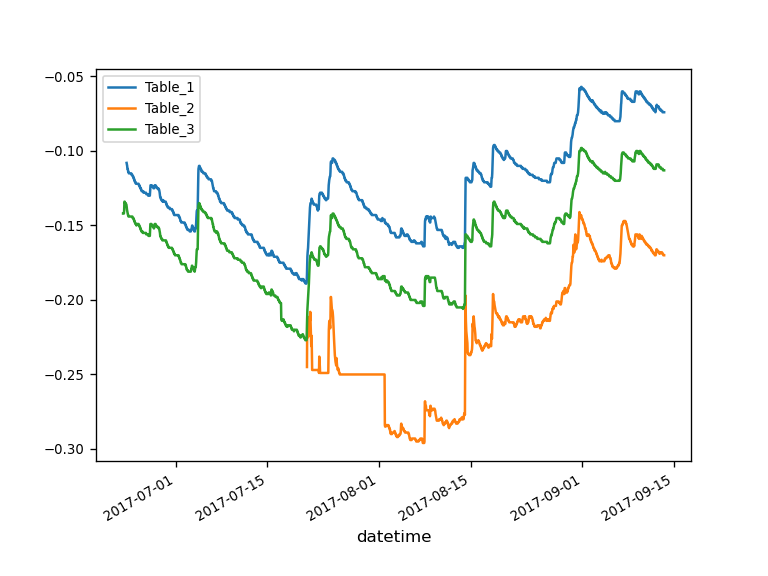

0.10863212237093749
0.03569097839898342


In [19]:
fig,ax=plt.subplots()# print((1-Week['Daytime'])*24)
T30[['Table_1','Table_2','Table_3']].plot(ax=ax)
print((T30['Table_1']-T30['Table_2']).mean())
print((T30['Table_1']-T30['Table_3']).mean())

<IPython.core.display.Javascript object>


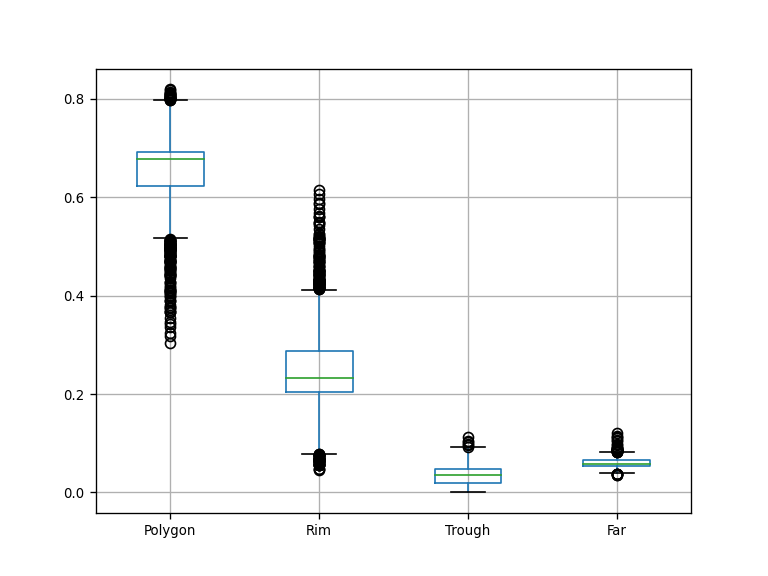

In [20]:
plt.figure()
# plt.plot()
T30['Trough'] = T30['Collapse']+0
T30['Far'] = T30['FarField']+0
T30[['Polygon','Rim','Trough','Far']].boxplot()

file_records       83
used_records       83
Tau                83
qc_Tau             83
rand_err_Tau        0
                   ..
ch4_flux_scaled    55
Week               83
DOW                83
Trough             83
Far                83
Length: 538, dtype: int64
file_records       79
used_records       79
Tau                79
qc_Tau             79
rand_err_Tau        0
                   ..
ch4_flux_scaled    51
Week               79
DOW                79
Trough             79
Far                79
Length: 538, dtype: int64


<IPython.core.display.Javascript object>


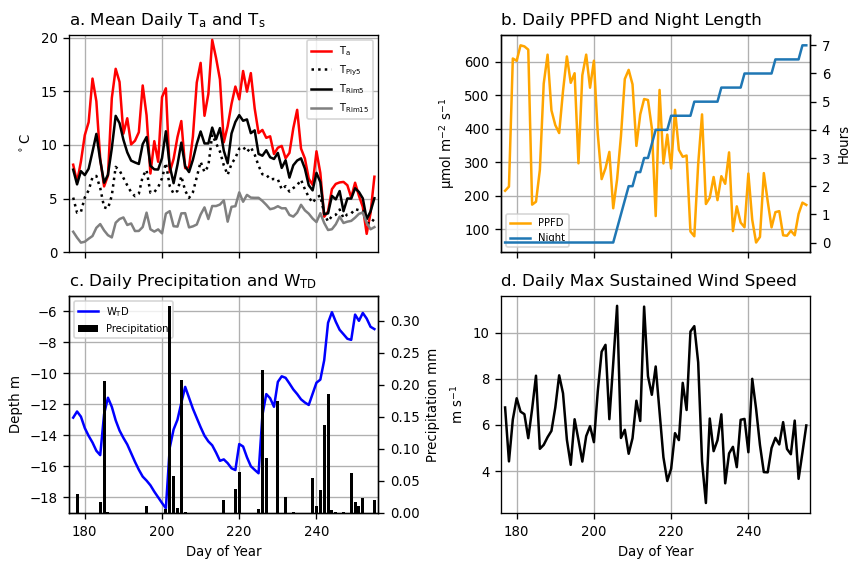

In [21]:
# fig = plt.figure(figsize=(6.5,7))

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Daily = T30.groupby('DOY').mean()
Daily['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').mean().values
Daily['Daytime'] = ((T30['Daytime']-1)**2).resample('D').sum().values/2
Daily['wind_speed'] = T30['wind_speed'].resample('D').max().values

print(Daily.count())
Daily = Daily[3:-1]
print(Daily.count())

fig,ax = plt.subplots(2,2,figsize=(18.2*cm,12*cm),sharex=True)

ax[1,0].set_title('c. Daily Precipitation and W$_{TD}$',loc='left')
ax[1,1].set_title('d. Daily Max Sustained Wind Speed',loc='left')
# ax[2,0].set_title('e.',loc='left')
ax[0,1].set_title('b. Daily PPFD and Night Length',loc='left')
ax[0,0].set_title('a. Mean Daily T$_{a}$ and T$_{s}$',loc='left')

ax[1,0].grid()
ax[1,1].grid()
ax[0,1].grid()
ax[0,0].grid()

ax[0,0].plot(Daily.index,Daily['AirTC_Avg'],color='r',label='T$_a$')
ax[0,0].set_ylabel('$^\circ$C')
ax[0,0].plot(Daily.index,Daily['Temp_5_1'],color='k',label='T$_{Ply5}$',linestyle=':')
ax[0,0].plot(Daily.index,Daily['Temp_5_2'],color='k',label='T$_{Rim5}$')
ax[0,0].plot(Daily.index,Daily['Temp_15_2'],color='grey',label='T$_{Rim15}$')
ax[0,0].legend()


ax[1,1].plot(Daily['wind_speed'],color='k',label='Sustained')


ax[1,1].set_ylabel('m s$^{-1}$')
ax[0,0].set_ylim(0,20.2)

ax[0,1].plot(Daily['PPFD_Avg'],color='orange',label='PPFD')
ax[0,1].set_ylabel('$\mu$mol m$^{-2}$ s$^{-1}$')
ax2 = ax[0,1].twinx()
ax[0,1].plot(Daily['Daytime']*np.nan,label='Night')
ax2.plot(Daily['Daytime'])
ax2.set_ylabel('Hours')
ax[0,1].legend(loc=3)

ax[1,0].plot(Daily['Table_1']*100,color='blue',label='W${_TD}$')
ax[1,0].set_ylabel('Depth m')
ax[1,0].set_ylim(-19,-5)

ax2=ax[1,0].twinx()
ax2.bar(Daily.index,Daily['Rain_mm_Tot'],color='k')
ax[1,0].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,color='k',label='Precipitation')
ax2.set_ylabel('Precipitation mm')
ax[1,0].legend()
ax[1,0].set_xlabel('Day of Year')

ax[0,1].set_xlim(Daily.index[0]-1,Daily.index[-1]+1)
ax[1,0].set_xlim(Daily.index[0]-1,Daily.index[-1]+1)
plt.tight_layout()
ax[1,1].set_xlabel('Day of Year')

plt.savefig('Conditions.jpg',dpi = 600)

fch4    0.280133
NME     0.335375
dtype: float64
fco2   -0.825211
NEE    -1.084838
dtype: float64


<IPython.core.display.Javascript object>


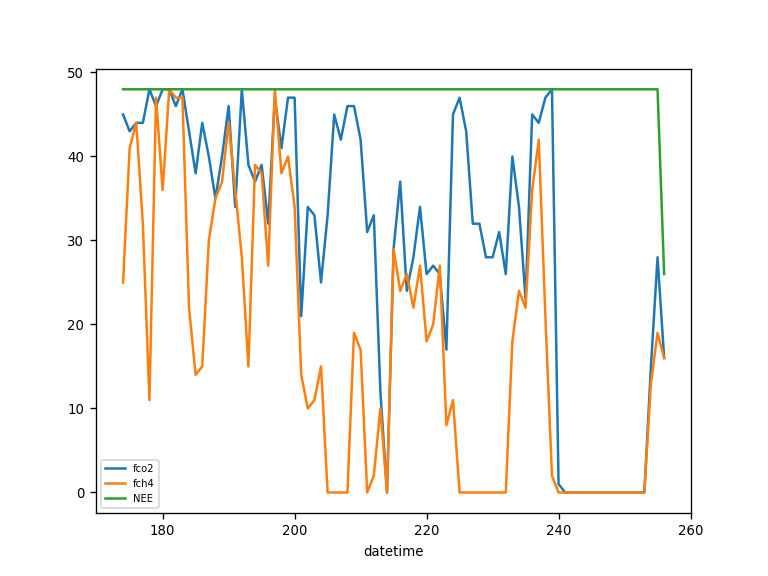

In [124]:
print(T30[['fch4','NME']].resample('D').mean().std()/T30[['fch4','NME']].resample('D').mean().mean())
print(T30[['fco2','NEE']].resample('D').mean().std()/T30[['fco2','NEE']].resample('D').mean().mean())
# print(T30.loc[T30.DOY==222].iloc[0])
# print(T30.loc[T30.DOY==225].iloc[0])
Temp = T30[['fco2','fch4','NEE']].resample('D').count()
Temp = Temp.set_index(Temp.index.dayofyear)
Temp[['fco2','fch4','NEE']].plot()
# plt.plot()

In [ ]:
import matplotlib.gridspec as gridspec

import matplotlib.dates as mdates
Lims = [
[datetime.datetime(2017,7,18,0), datetime.datetime(2017,7,25,0)],
# [datetime.datetime(2017,6,30,0), datetime.datetime(2017,7,6,0)],
[datetime.datetime(2017,8,10,0), datetime.datetime(2017,8,13,0)],
# [datetime.datetime(2017, 8, 21), datetime.datetime(2017, 8, 28)]
       ]
Names = ['Week 5: NME and Rn','Week 8: NME and Rn']

fig,ax=plt.subplots(4,2,figsize=(6.5,7),sharex='col',sharey='row')
i = -1

import matplotlib.ticker
nticks = 4
for Lim,Name in zip(Lims,Names):
    i+=1
    Temp = T30.loc[(T30.index.tz_localize(None)>=Lim[0]) & (T30.index.tz_localize(None)<Lim[1])]
#     Temp =
#     print(Temp['max_wind_speed'].max())

    ax[0,i].plot(Temp['ch4_flux']*1e3,color='r',marker='*',linewidth=0,label='Measured F$_{CH4}$')
    ax[0,i].plot(Temp['NME_est'],color='b',label='Modeled NME')
#     ax[0,i].set_zorder(x2.get_zorder()+1) # put ax in front of ax2
    ax[0,i].patch.set_visible(False) # hide the 'canvas'

    
    ax[0,i].set_xlim(Lim[0],Lim[1])
    ax[0,i].set_ylim(T30['ch4_flux'].min()*1e3-T30['ch4_flux'].min()*1e3*.05,T30['ch4_flux'].max()*1e3+T30['ch4_flux'].max()*1e3*.05)
    ax[0,i].legend(loc=1)

    ax[0,i].set_title(Name,loc='left')
    ax[0,i].grid()
    ax[0,i].axhspan(yl2[0],0, facecolor='0.2', alpha=0.25)
#     ax2.set_ylim(-100,650)
    l = ax[0,i].get_ylim()
    l2 = ax2.get_ylim()
    if i == 0:
        ax[0,i].set_ylabel('CH$_4$ nmol m$^{-2}$ s$^{-1}$')
    ax[1,i].plot(Temp.resample('H').mean()['NR_Wm2_Avg'],color='k',label='Rn')
    if i == 0:
        ax[1,i].set_ylabel('W m$^{-2}$ s$^{-1}$')
    ax[1,i].set_title('Rn',loc='left')
    ax[1,i].grid()
    ax[2,i].plot(Temp['wind_speed'],color='grey',label='U')
    ax[2,i].set_ylim(0,12)
    ax[2,i].plot(T30['air_pressure']*np.nan,label='Pa')
    ax2=ax[2,i].twinx()
    ax2.plot(T30['air_pressure']*1e-3,label='Pa')
    ax2.set_ylim(T30['air_pressure'].min()*1e-3-T30['air_pressure'].min()*1e-3*.001,T30['air_pressure'].max()*1e-3+T30['air_pressure'].max()*1e-3*.001)
    ax[2,i].legend()
    ax[2,i].set_xlim(Lim[0],Lim[1])
    ax[2,i].set_title('Wind and Pressure',loc='left')
    ax[2,i].grid()

    l = ax[2,i].get_ylim()
    l2 = ax2.get_ylim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax[2,i].get_yticks())
    print(ticks)
    ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
    ax2.set_yticklabels(np.round(ax2.get_yticks(),1))
    
    if i == 0:
        ax[2,i].set_ylabel('m s$^{-1}$')
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel('kPa')
    
    

    ax[3,i].plot(Temp['Table_1'],label='W$_{td}$',color=[.1,.2,.8],linewidth=1.4)
    ax[3,i].set_ylim(-.2,-.05)
    ax2=ax[3,i].twinx()
    ax2.bar(Temp.index,Temp['Rain_mm_Tot'],color='k',label='Precipitation',width=.01,edgecolor='k')
    ax2.set_ylim(T30['Rain_mm_Tot'].min(),3)
    ax[3,i].bar(Temp.index,Temp['Rain_mm_Tot']*np.nan,color='k',label='Precipitation',width=.0,edgecolor='k')
    ax[3,i].legend(loc=2)
    ax[3,i].set_xlim(Lim[0],Lim[1])
    ax[3,i].set_title('Water Table & Precipitation',loc='left')
    ax[3,i].set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax[3,i].xaxis.set_major_locator(locator)
    ax[3,i].xaxis.set_major_formatter(formatter)
    ax[3,i].patch.set_visible(False) 
    ax[3,i].grid()
    print(Temp['Table_1'].max()-Temp['Table_1'].min())

    

    l = ax[3,i].get_ylim()
    l2 = ax2.get_ylim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax[3,i].get_yticks())
    ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
#     ax2.set_yticklabels(np.round(ax2.get_yticks(),1))
    
#     if i == 0:
#         ax[3,i].set_ylabel('Depth m')
#         ax2.set_yticklabels([])
#     else:
#         ax2.set_ylabel('Precipitation mm')
# ax[0,0].set_xlim(Lims[0][0],Lims[0][1])
# ax[0,1].set_xlim(Lims[0][0],Lims[0][1])
plt.tight_layout()
#     plt.suptitle('Case '+str(i+1))
plt.savefig('CaseStudies.png')
print(T30.loc[np.isnan(T30['ch4_flux'])==False,'fch4'].count()/T30['NME'].count())
# print(T30.loc[np.isnan(T30['co2_flux'])==False,'fco2'].count()/T30['NME'].count())
print(T30['max_wind_speed'].max())
print(T30.loc[T30['ch4_flux']==T30['ch4_flux'].max(),['NME','ch4_flux']]*1e3)

In [ ]:

U = T30.loc[((T30.Month==7)&(T30.Hour>=10)&(T30.Hour<=17)),'ch4_flux'].median()
S = T30.loc[((T30.Month==8)&(T30.Hour>=0)&(T30.Hour<=24)),'ch4_flux'].std()
C = T30.loc[((T30.Month==8)&(T30.Hour>=0)&(T30.Hour<=24)),'ch4_flux'].count()
print(U*mult['fch4']*1e6*2)

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(3.5,4))
ax[0].grid()
# print(T30.index[0:48])

Wgroup = 'W-Thu'
Weekly = T30.resample(Wgroup).mean()
Weekly_Std = T30.resample(Wgroup).std()
Weekly_Count = T30.resample(Wgroup).count()


print(Weekly.index)
Weekly = Weekly.reset_index()
Weekly_Std = Weekly_Std.reset_index()
Weekly_Count = Weekly_Count.reset_index(drop=True)

# Weekly=Weekly[1:]
# Weekly_Std=Weekly_Std[1:]
# Weekly_Count=Weekly_Count[1:]

ax[0].bar(Weekly.index+1,Weekly['ER_est'],
          yerr=Weekly_Std['ER_est']/Weekly_Count['ER_est']**.5*stats.t.ppf(1-.025,Weekly_Count['ER_est']),
          width=.9,edgecolor='k',color=Color['ER_est'],label='ER')

ax[0].bar(Weekly.index+1,Weekly['NEE']-Weekly['ER_est'],
          width=.9,edgecolor='k',color=Color['GPP_est'],label='GPP')

ax[0].bar(Weekly.index+1,Weekly['NEE'],
          yerr=Weekly_Std['NEE']/Weekly_Count['NME']**.5*stats.t.ppf(1-.025,Weekly_Count['NME']),
          width=.8,edgecolor='k',color=Color['NEE'],label='NEE')

ax[0].legend()


ax[1].bar(Weekly.index+1,Weekly['NME'],
          yerr=Weekly_Std['NME']/Weekly_Count['NME']**.5*stats.t.ppf(1-.025,Weekly_Count['NME']),
          width=.9,edgecolor='k',color=Color['NME'])
ax[1].grid()

ax[1].set_xticks([1,3,5,7,9,11])

ax[0].set_title('a. NEE, ER, & GPP',loc='left')
ax[1].set_title('b. NME',loc='left')


ax[0].set_ylabel('g C-CO$_2$ m$^{-2}$ day$^{-1}$')
ax[1].set_ylabel('mg C-CH$_4$ m$^{-2}$ day$^{-1}$')
ax[1].set_xlabel('Week No.')

al = ax[0].get_xlim()
ax[0].plot(al,[0,0],color='k')
ax[0].set_xlim(al)

plt.tight_layout()
plt.savefig('Weekly.png',dpi=300)

print(Weekly[['NEE','NME']].max()*48)
print(Weekly[['NEE','NME']].min()*48)


In [ ]:
print(T30.loc[T30['Daytime']<1,'DOY'])

# Mapping Taglu data. don't delete!

In [ ]:
fch4_Taglu = ResultMap('fch4',Test='SE',Rule=1,DataName='TagluData.csv',AltPath='Taglu')
fco2_Taglu = ResultMap('fco2',Test='SE',Rule=1,DataName='TagluData.csv',AltPath='Taglu')

print(fch4_Taglu.Model_Selection)
print(fco2_Taglu.Model_Selection)

In [ ]:
Taglu = pd.read_csv('C:\\Users\\wesle\\NetworkAnalysis/FishIsland//TagluRecord.csv')
Taglu['fco2']=np.nan
Taglu['fch4']=np.nan
Taglu.head()
Taglu = Taglu.set_index(pd.DatetimeIndex(Taglu.TIMESTAMP))
Taglu = Taglu.loc[pd.isnull(Taglu.index)==False]
Taglu = Taglu.loc[(Taglu.index.year>2008)&(Taglu.index.year<2019)]
Taglu.loc[Taglu['SoilMoist(4)']<20,'SoilMoist(4)']=np.nan
Taglu['Temp'] = Taglu['SoilMoist(4)'].interpolate()


In [ ]:

Taglu = Mapper(Taglu,fch4_Taglu,'NME_est',Fill = False)
Taglu = Mapper(Taglu,fco2_Taglu,'NEE_est',Fill = False)
print('Done')

In [ ]:
# print(Taglu.head())#[['NME_Est','NEE_Est']].mean())
Taglu['Month']=Taglu.index.month.values
Taglu = Taglu.loc[((Taglu.Month>5) & (Taglu.Month<10))]
# print(Taglu.head())

print(Taglu[['NEE_est','NME_est']].mean())

Yearly = (Taglu.groupby(Taglu.index.year).mean())
print(Yearly[['NEE_est','NME_est']])


Monthly = (Taglu.groupby('Month').mean())
print(Monthly[['NEE_est','NME_est']])
plt.figure()
plt.plot(Taglu['NEE_est'].resample('Y').mean())
x2=plt.twinx()
x2.plot(Taglu['NME_est'].resample('Y').mean(),color='r')


plt.figure()
plt.plot(Taglu['NEE_est'].groupby(Taglu.index.dayofyear).mean())
x2=plt.twinx()
x2.plot(Taglu['NME_est'].groupby(Taglu.index.dayofyear).mean(),color='r')

In [ ]:
plt.figure()
plt.scatter(Taglu['WindSpd'],Taglu['NME_est'])
# plt.plot(Taglu['NME_est'])

In [ ]:
# plt.figure()
# Temp = Taglu.loc[Taglu.Month==8]
# plt.scatter(Temp['SoilMoist(2)'],Temp['SoilMoist(4)'])
# # plt.plot(Taglu['SoilMoist(1)'].resample('Y').count())

In [ ]:
y=2015
fig=plt.figure()
plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(4)']])
# plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(1)']])
plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(2)']])
x2 = plt.twinx()
plt.plot(Taglu.loc[Taglu.index.year==y].Rainfall_Tot.cumsum())
# plt.plot(Taglu.loc[Taglu.index.year==y,['NME_est']])
fig.autofmt_xdate()

In [ ]:
plt.figure()
plt.scatter(T30['fch4'],T30['Table_1'])
print(T30[['fch4','Table_1']].corr())